In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

def plot(df):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 30))

    for i in [0, 10, 30, 50]:
        normal, detach = extract(df, i)
        if i == 0:
            z = 0
        elif i == 10:
            z = 1
        elif i == 30:
            z = 2
        else:
            z = 3
            
        ax = axes[z, 0]
        ax_log = axes[z, 1]

        ax_log.set_title("Param strSize: %s" % i)    
        normal.plot(ax = ax_log, x = "Param: size", y = "Score", logx = True, logy = True, color = "green", label = "normal")
        detach.plot(ax = ax_log, x = "Param: size", y = "Score", logx = True, logy = True, color = "red", label = "detach")
        
        ax.set_title("Param strSize: %s" % i)    
        normal.plot(ax = ax, x = "Param: size", y = "Score", logx = True, color = "green", label = "normal")
        detach.plot(ax = ax, x = "Param: size", y = "Score", logx = True, color = "red", label = "detach")
    
    plt.tight_layout()
    
def plot1(df1, df2):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

    for i in [0, 10, 30, 50]:
        _, detach1 = extract(df1, i)
        _, detach2 = extract(df2, i)
        
        if i == 0:
            z = 0
        elif i == 10:
            z = 1
        elif i == 30:
            z = 2
        else:
            z = 3
            
        ax = axes[z, 0]
        ax_log = axes[z, 1]

        ax_log.set_title("Param strSize: %s" % i)    
        detach1.plot(ax = ax_log, x = "Param: size", y = "Score", logx = True, logy = True, color = "green", label = "master")
        detach2.plot(ax = ax_log, x = "Param: size", y = "Score", logx = True, logy = True, color = "red", label = "fix")
        
        ax.set_title("Param strSize: %s" % i)    
        detach1.plot(ax = ax, x = "Param: size", y = "Score", logx = True, color = "green", label = "master")
        detach2.plot(ax = ax, x = "Param: size", y = "Score", logx = True, color = "red", label = "fix")
    
    plt.tight_layout()    

        
def prepare(df):
    df["Benchmark"] = df["Benchmark"].apply(lambda x: x.split('.')[-1])
    
    return df

def extract(df, strSize):
    normal = df[(df["Param: strSize"] == 0) & (df["Benchmark"] == "testUnmarshalling")]
    detach = df[(df["Param: strSize"] == 0) & (df["Benchmark"] == "testUnmarshallingDetach")]
    
    return normal, detach

In [2]:
from scipy.optimize import curve_fit
import numpy as np

def func(x, a, b):
    return a*x  + b

def func1(x, a, b):
    return np.power(10, b)*np.power(x, a)

### Run master vs fix detach: 1G Heap

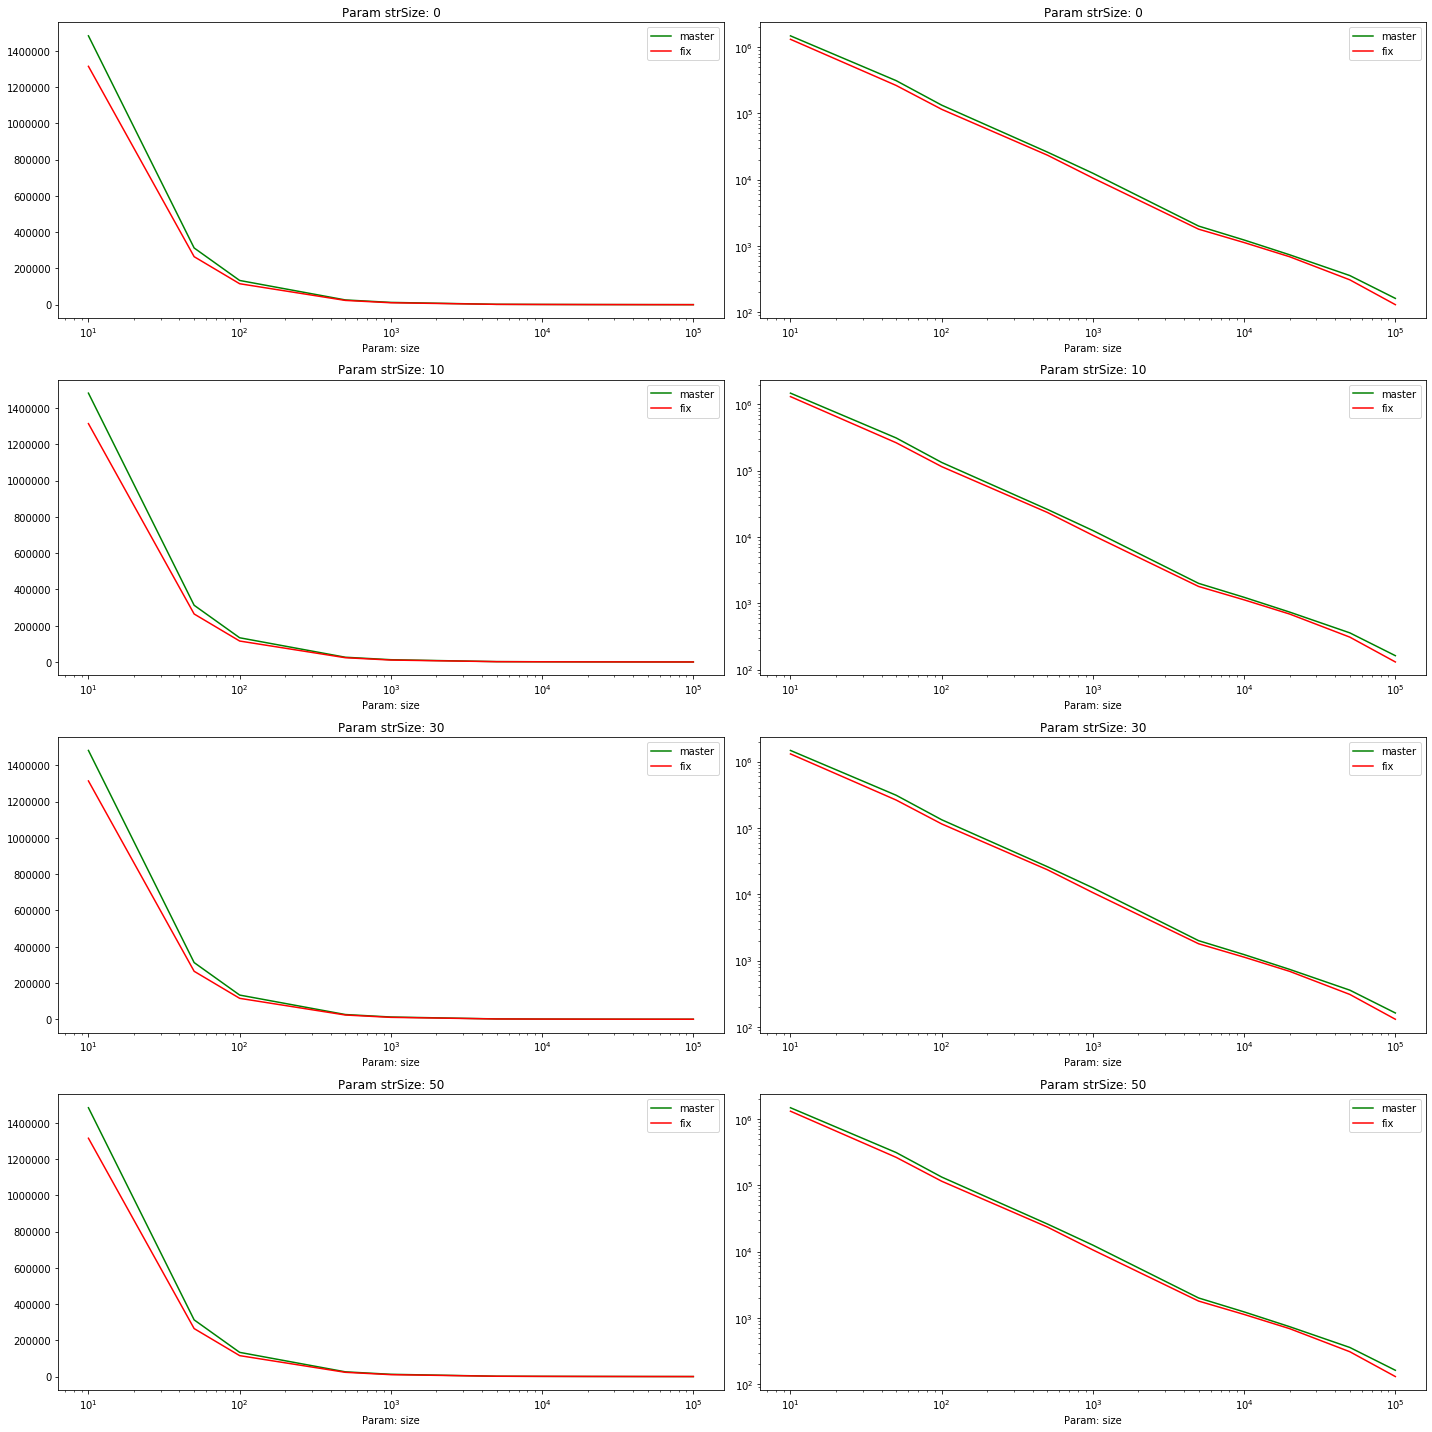

In [3]:
master_1g = prepare(pd.read_csv("data/master_1G.csv"))
fix_1g = prepare(pd.read_csv("data/fix_1G.csv"))

plot1(master_1g, fix_1g)

### Run master vs fix detach: 512m Heap

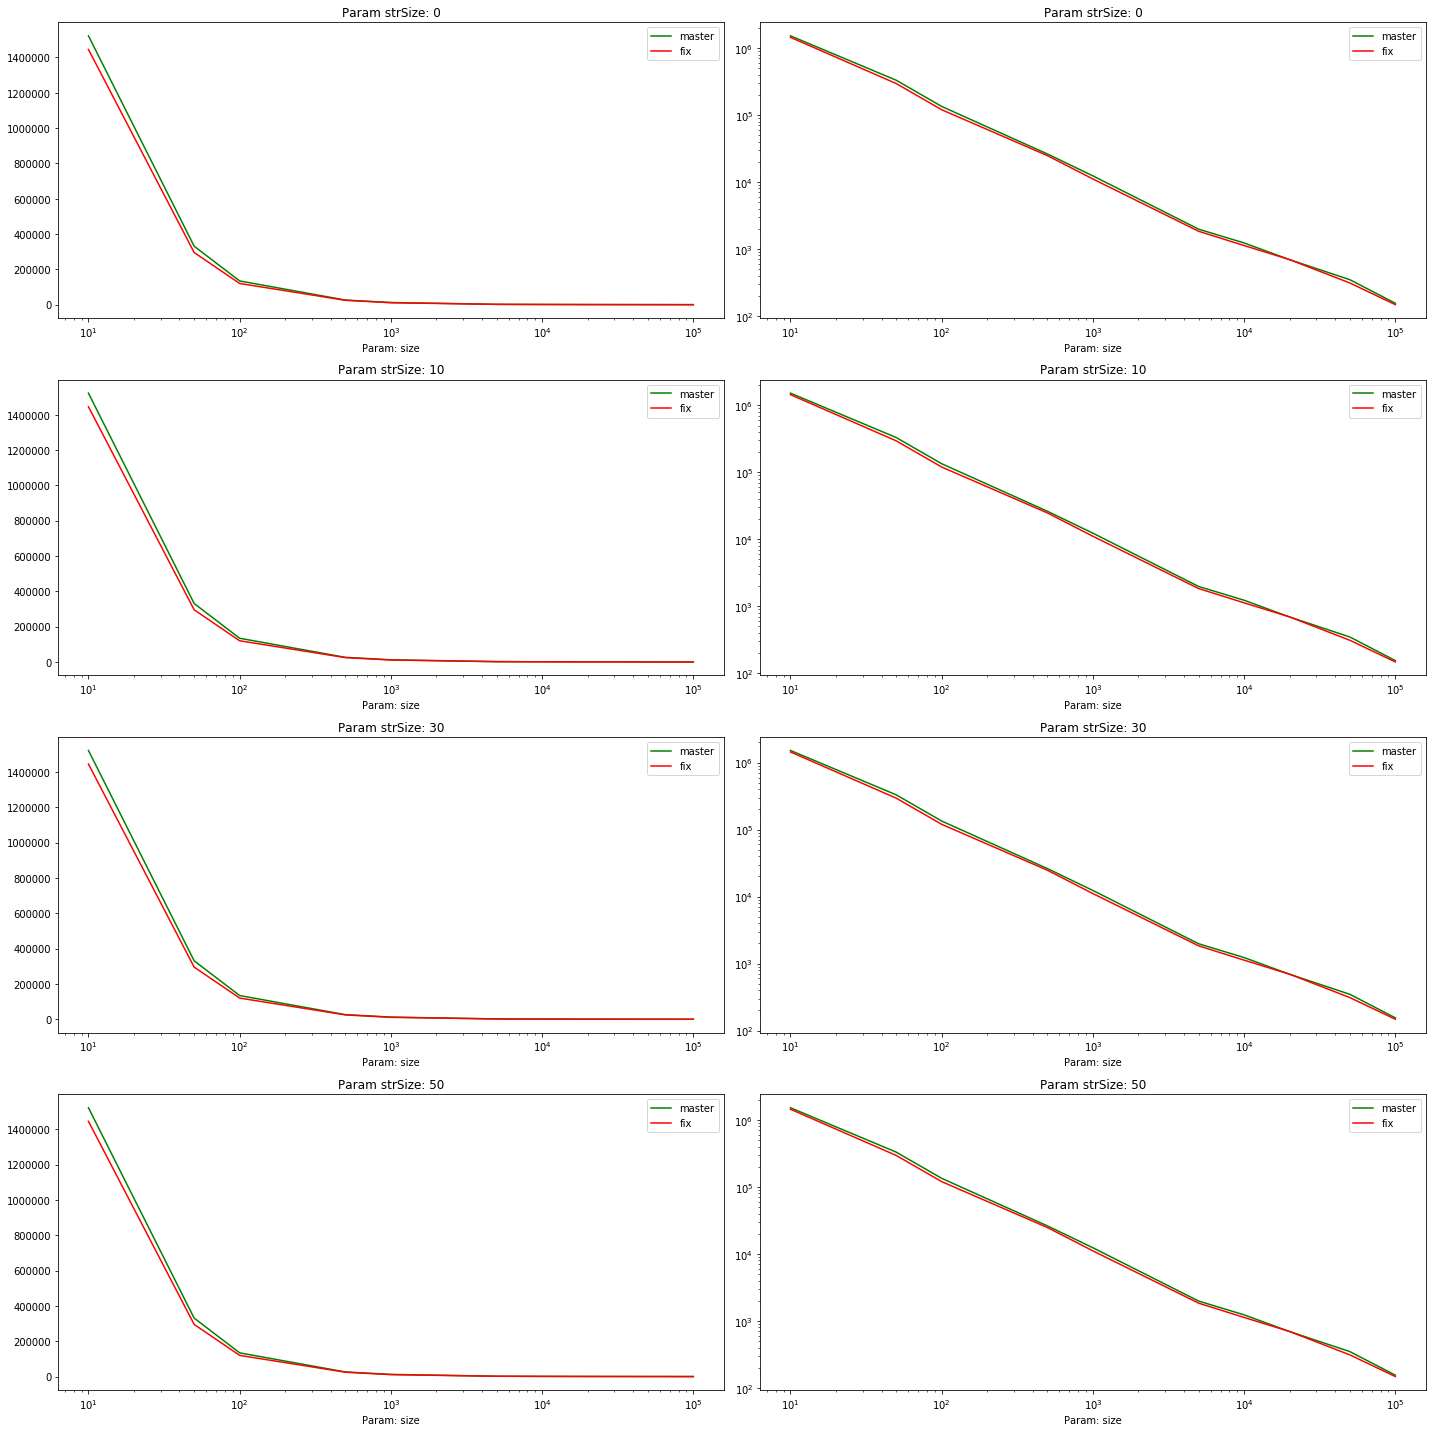

In [4]:
master_512 = prepare(pd.read_csv("data/master_512m.csv"))
fix_512 = prepare(pd.read_csv("data/fix_512m.csv"))

plot1(master_512, fix_512)

### Run master vs fix detach: 256m Heap

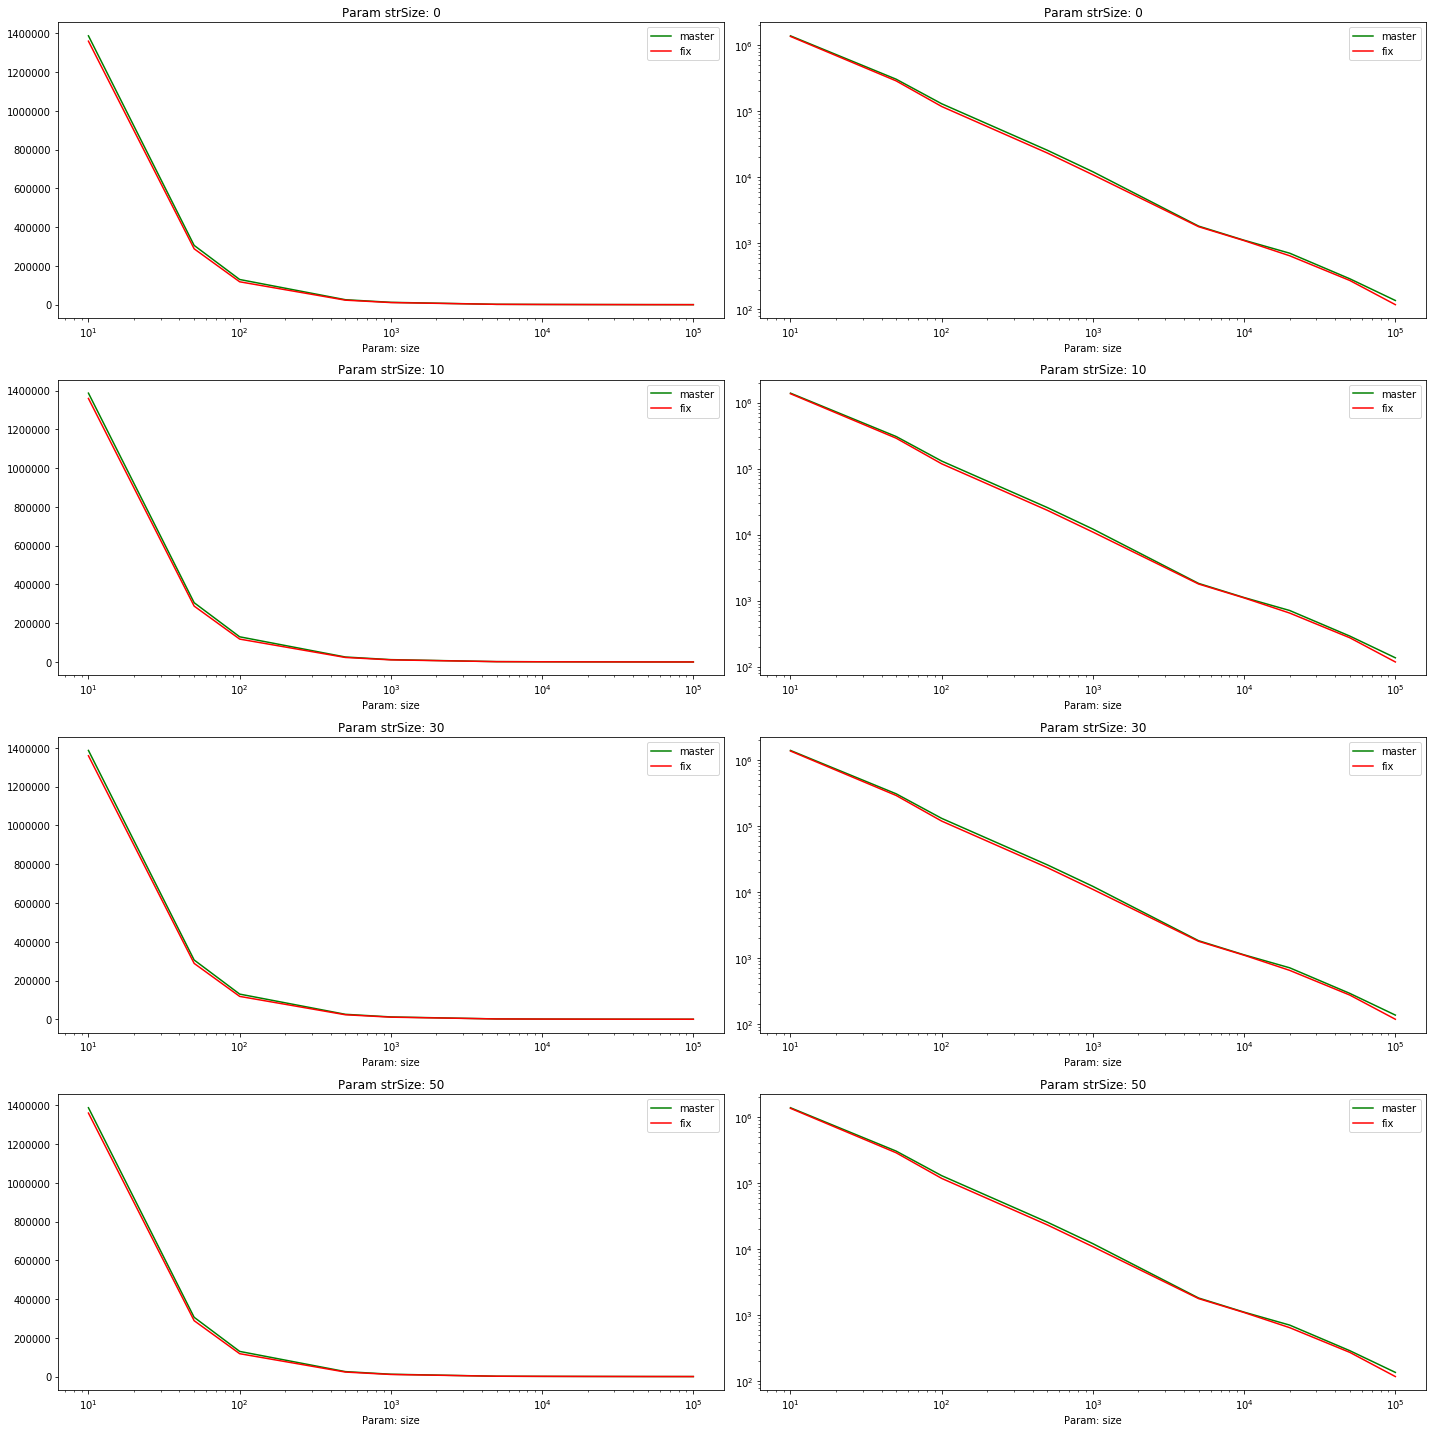

In [5]:
master_256 = prepare(pd.read_csv("data/master_256m.csv"))
fix_256 = prepare(pd.read_csv("data/fix_256m.csv"))

plot1(master_256, fix_256)

### Run master vs fix detach: 128m

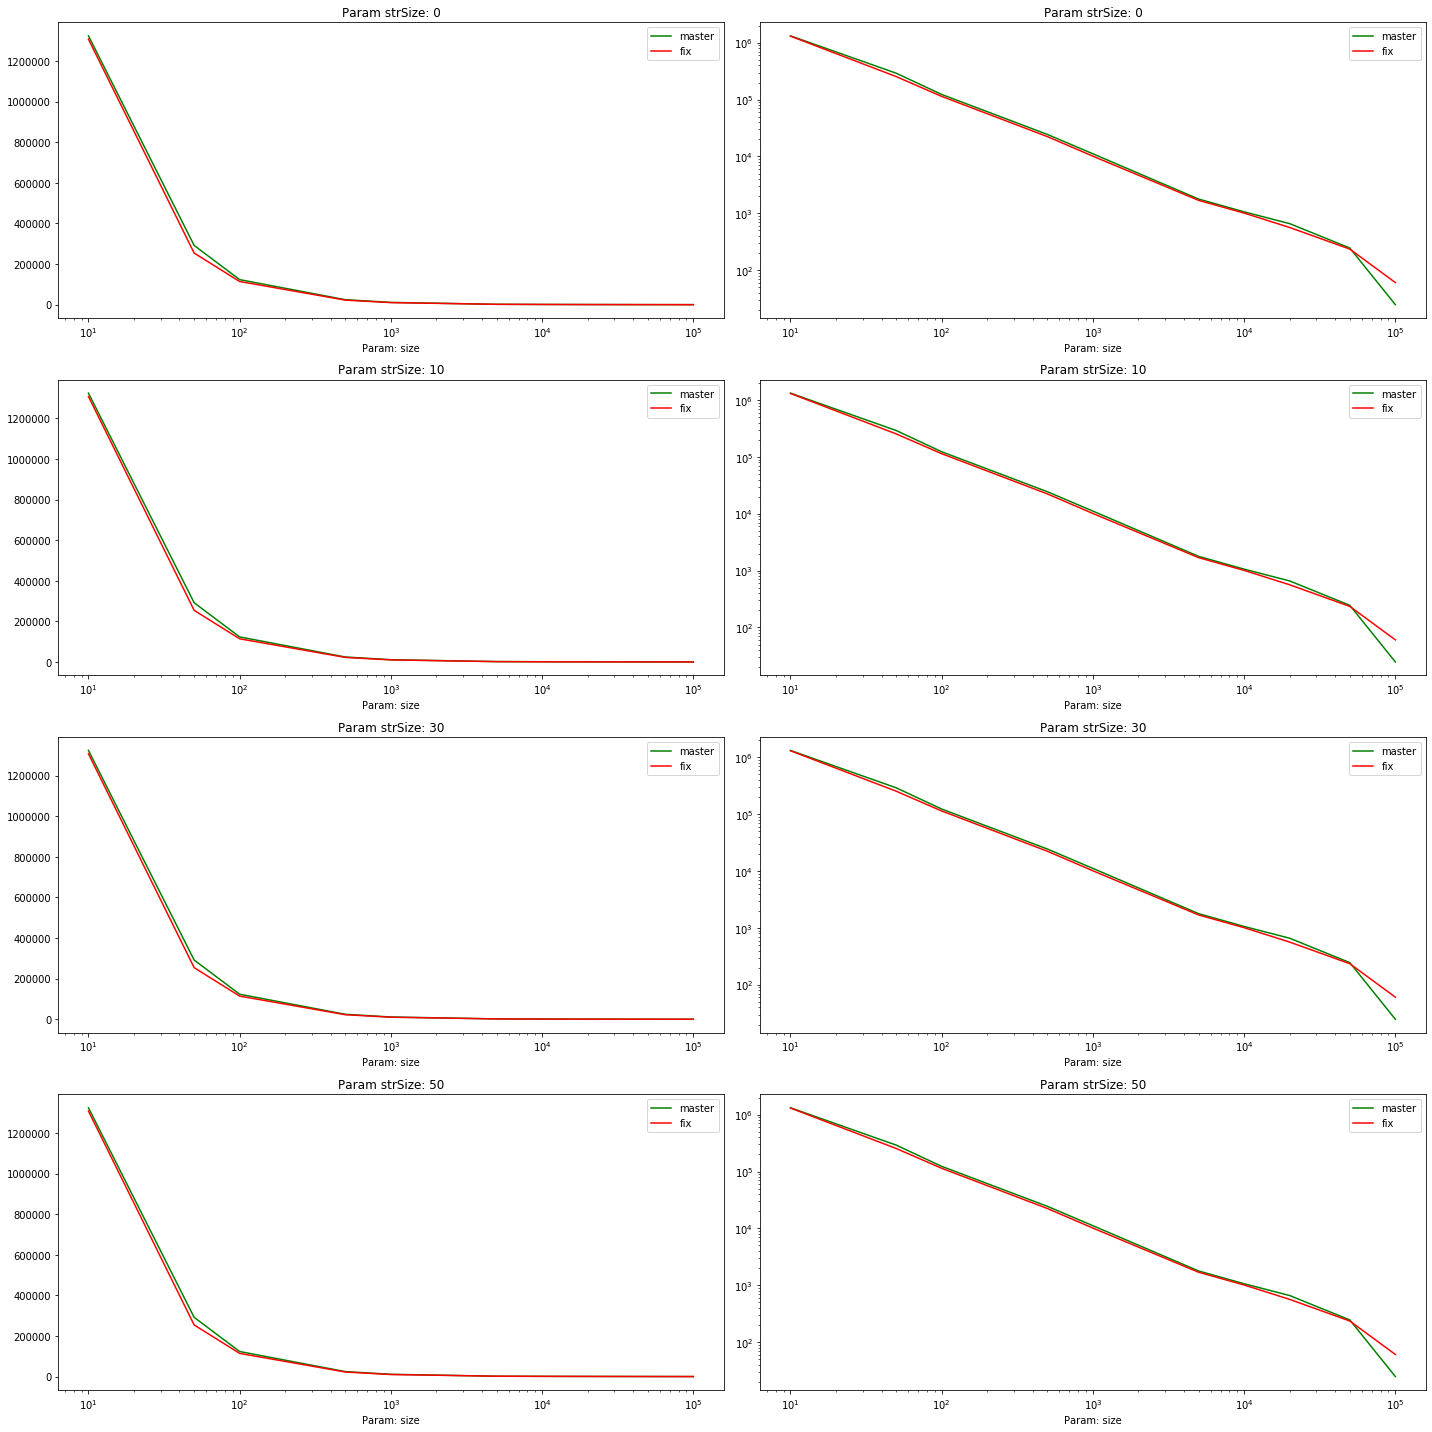

In [6]:
master_128 = prepare(pd.read_csv("data/master_128m.csv"))
fix_128 = prepare(pd.read_csv("data/fix_128m.csv"))

plot1(master_128, fix_128)

### Run master vs fix detach: 64m

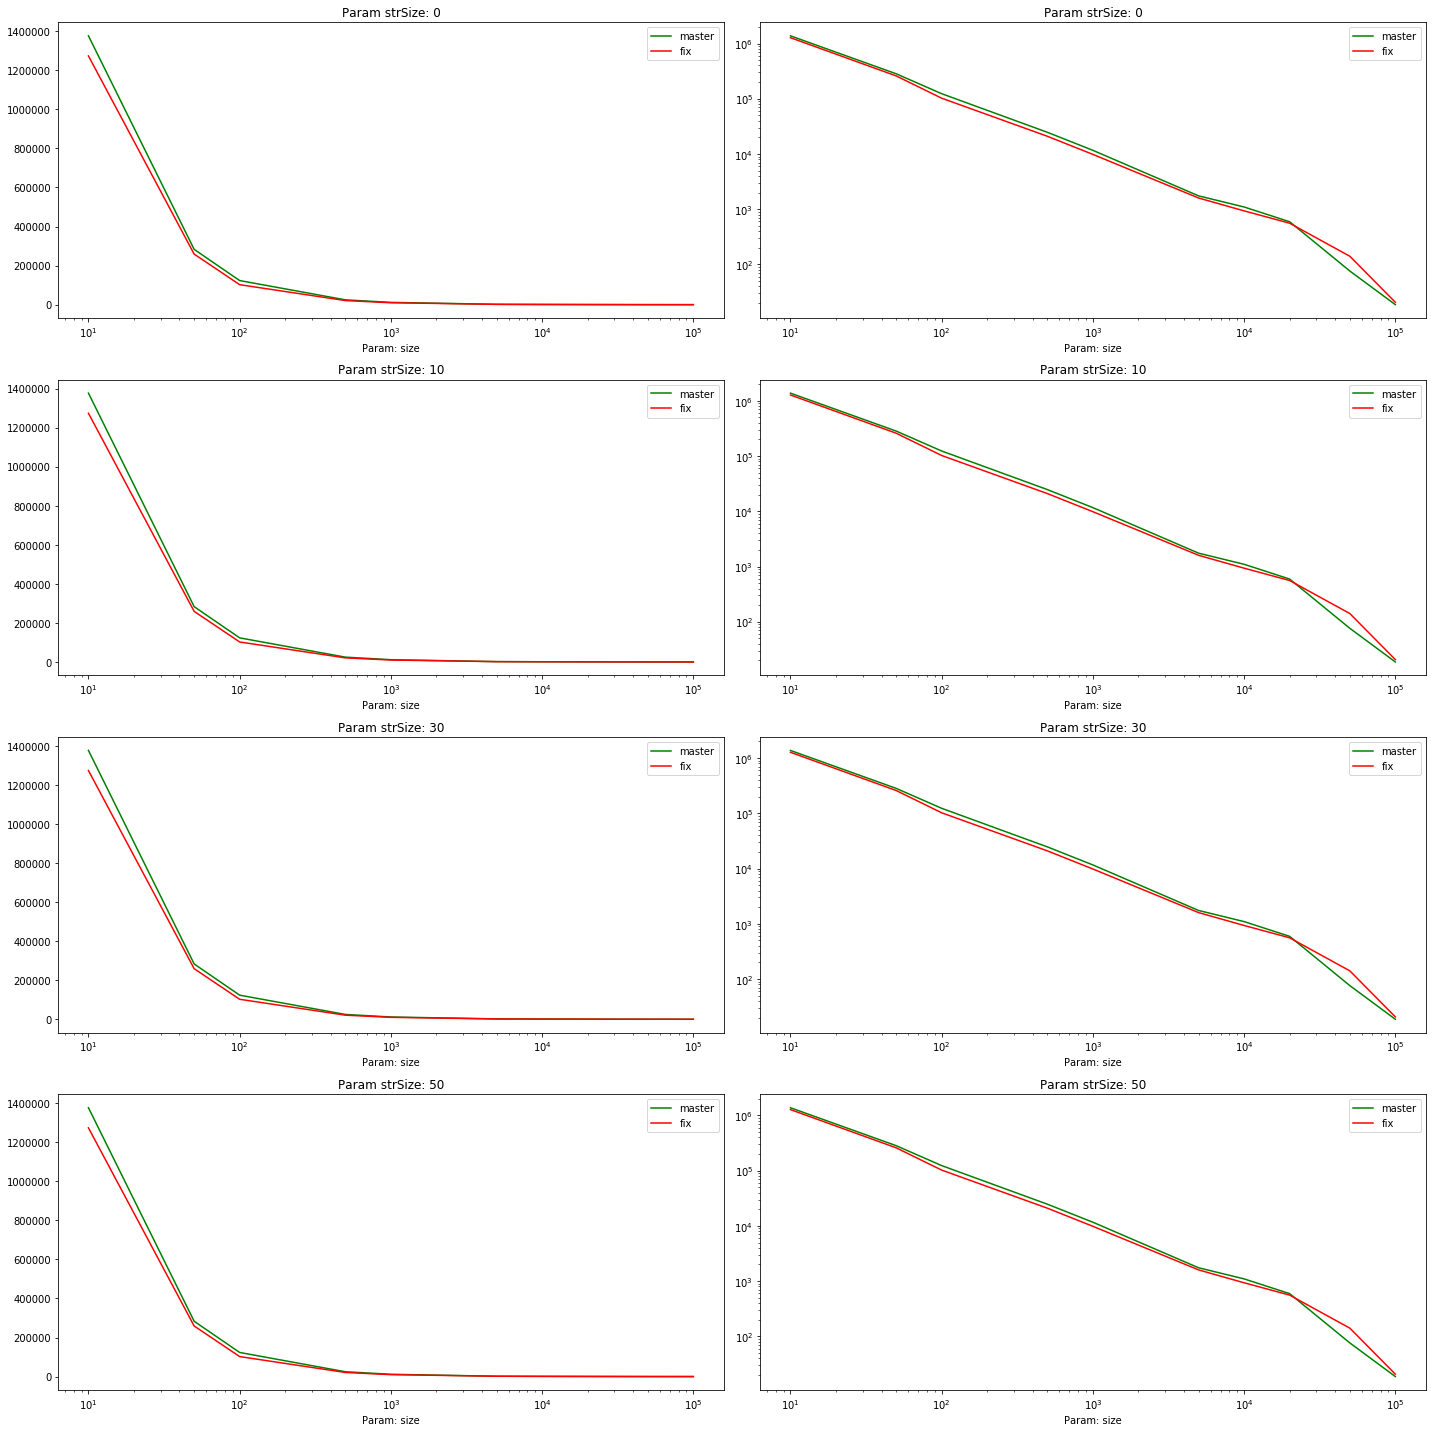

In [24]:
master_64 = prepare(pd.read_csv("data/master_64m.csv"))
fix_64 = prepare(pd.read_csv("data/fix_64m.csv"))

plot1(master_64, fix_64)

## Interpolation

As we see, in both logarithmic scale function is linear.
So lets find fitting function in form:
$$ \log_{10}(y) = a\log_{10}(x) + b$$

Real function shold be:
$$ y = 10^{b} x^{a} $$

In [7]:
from scipy.optimize import curve_fit
import numpy as np

def func(x, a, b):
    return a*x  + b

def func1(x, a, b):
    return np.power(10, b)*np.power(x, a)

def optimize(df):
    xdata = df["Param: size"]
    ydata = df["Score"]
    popt, pcov = curve_fit(func, np.log10(xdata), np.log10(ydata))
    
    return popt;

def fit(df_master, df_fix):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 30))

    for i in [0, 10, 30, 50]:
        _, detach_master = extract(df_master, i)
        _, detach_fix = extract(df_fix, i)

        popt_master = optimize(detach_master)
        popt_fix = optimize(detach_fix)

        if i == 0:
            z = 0
        elif i == 10:
            z = 1
        elif i == 30:
            z = 2
        else:
            z = 3

        for j in [0, 1]:
            data = detach_master if j == 0 else detach_fix
            popt = popt_master if j == 0 else popt_fix

            xdata = data["Param: size"]
            ydata = data["Score"]

            ax = axes[z, j]

            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.plot(xdata, func1(xdata, *popt), label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
            ax.plot(xdata, ydata, color="green", label="real")
            ax.set_title("%s. Param strSize: %s" % ("master" if j == 0 else "fix", i))
            ax.legend()

    plt.show()

### Fit for 1G

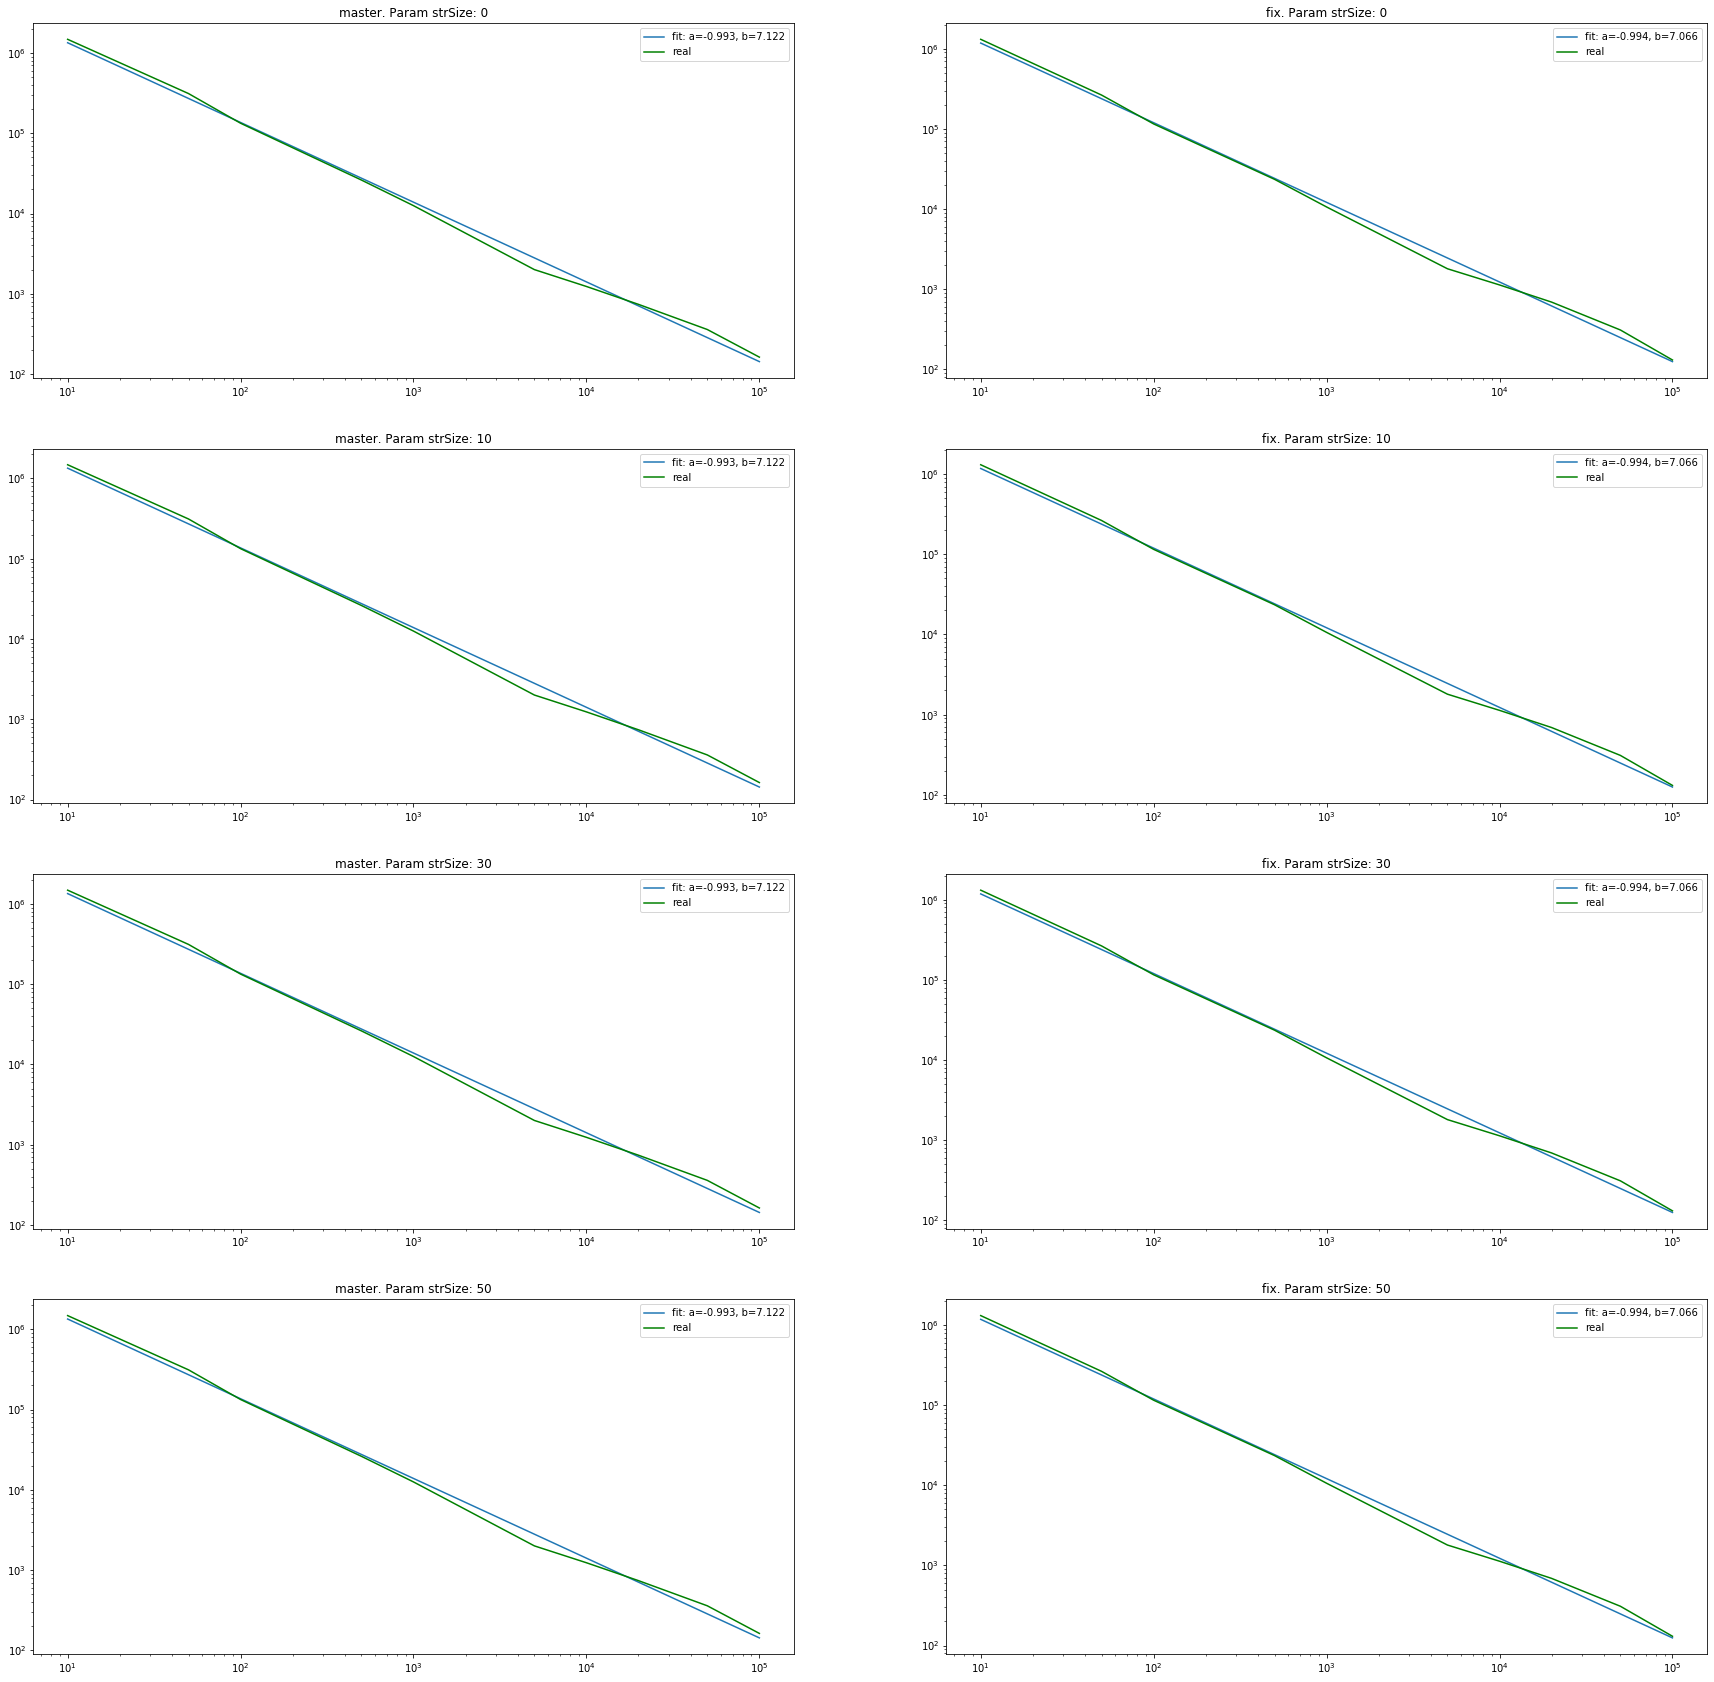

In [8]:
fit(master_1g, fix_1g)

## Fit for 512m

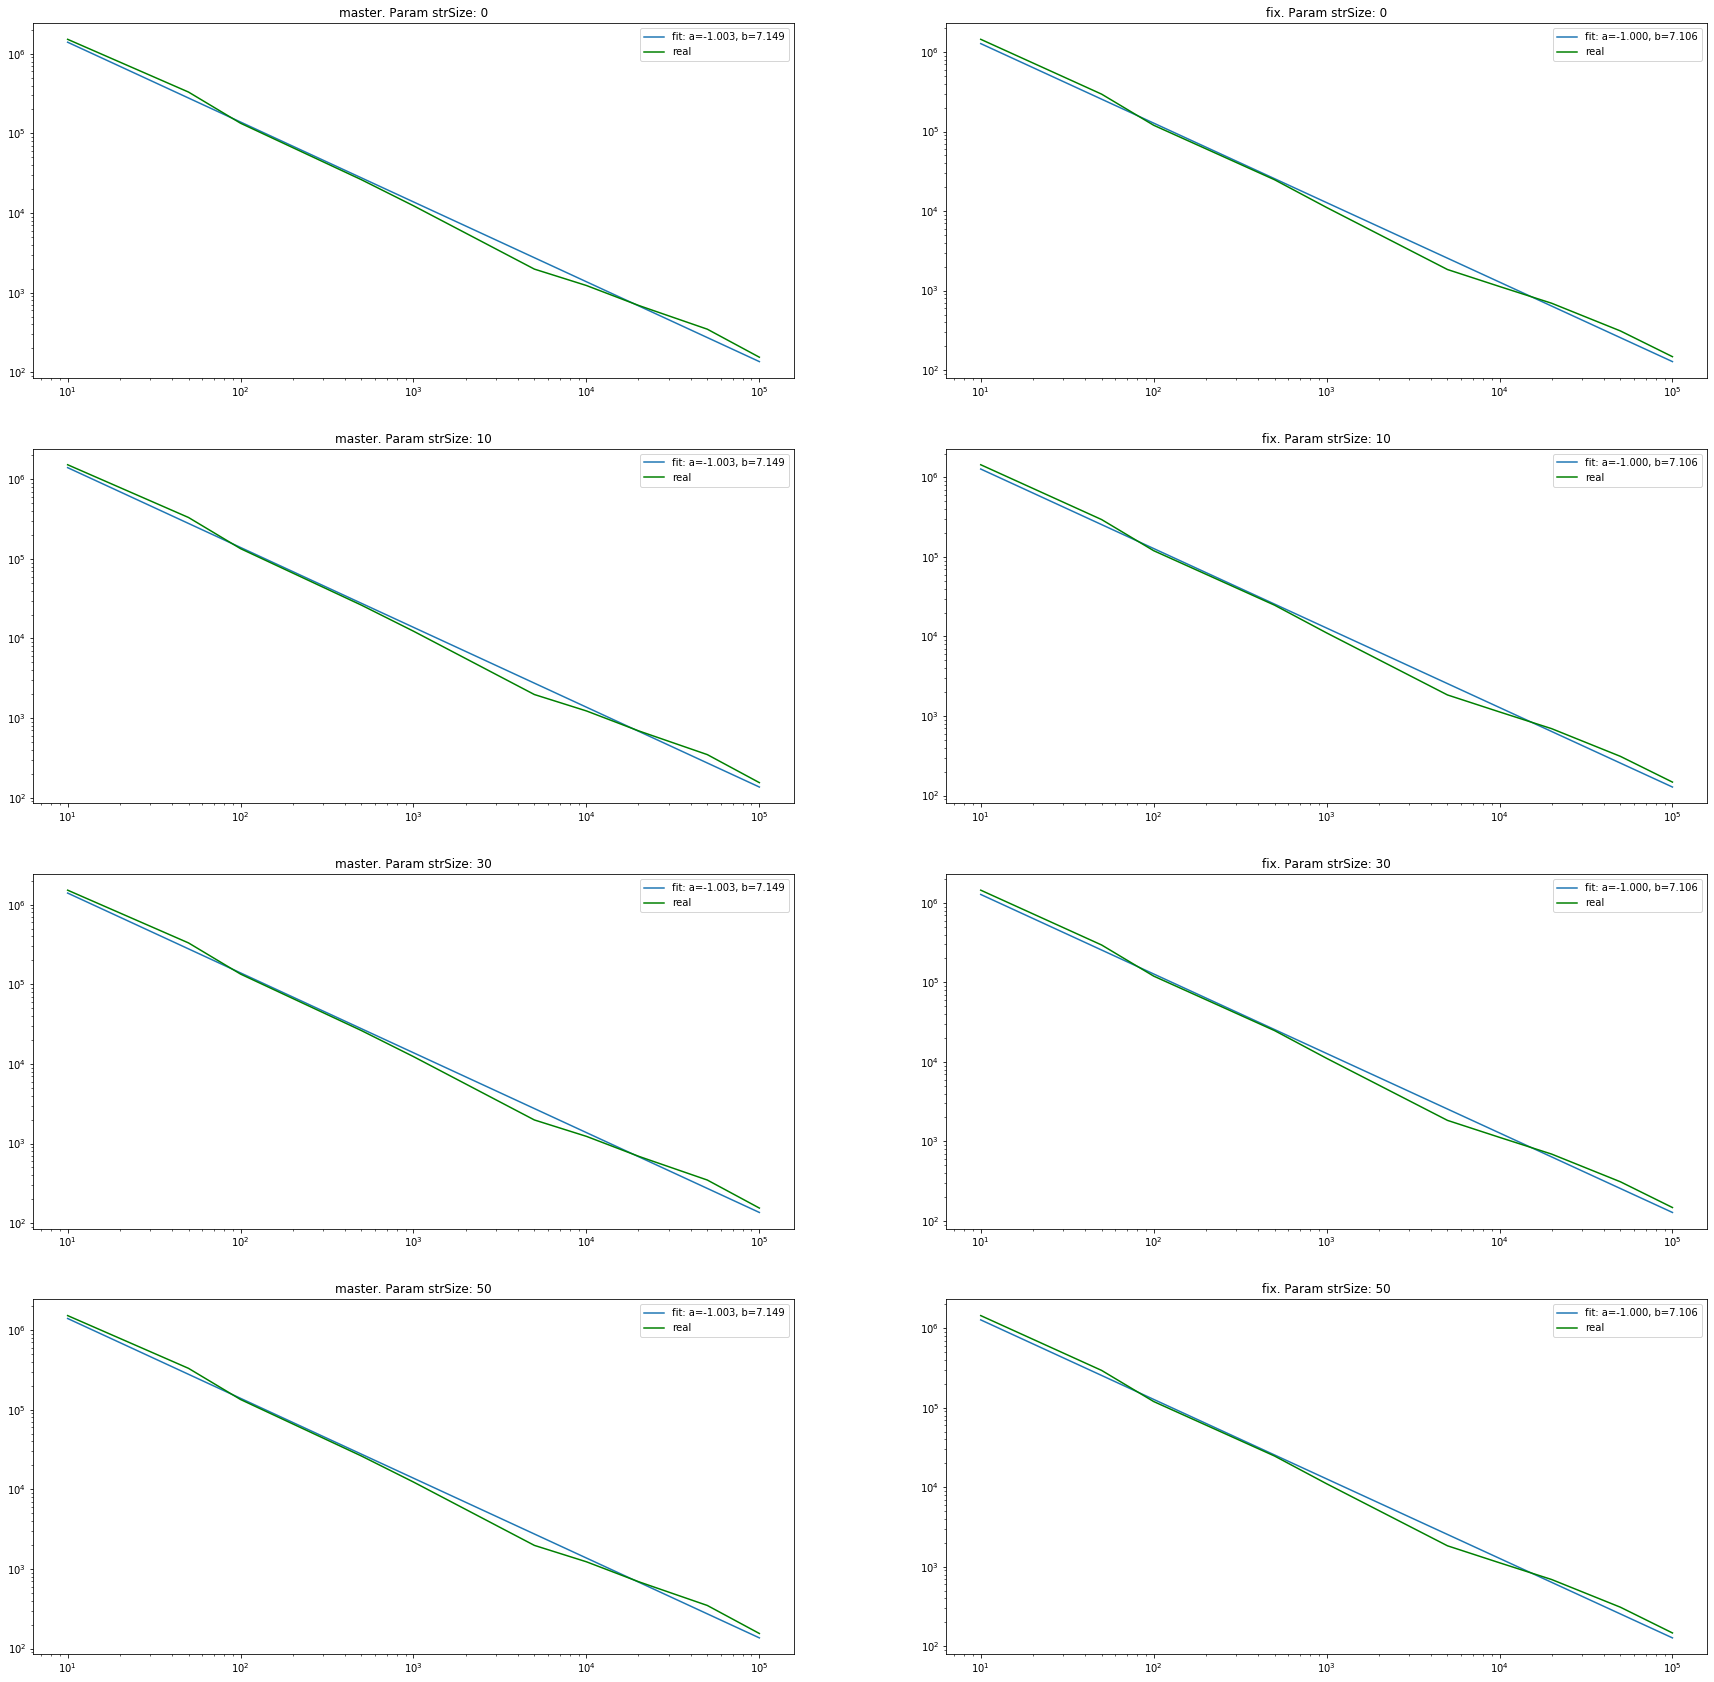

In [9]:
fit(master_512, fix_512)

## Fit for 256m

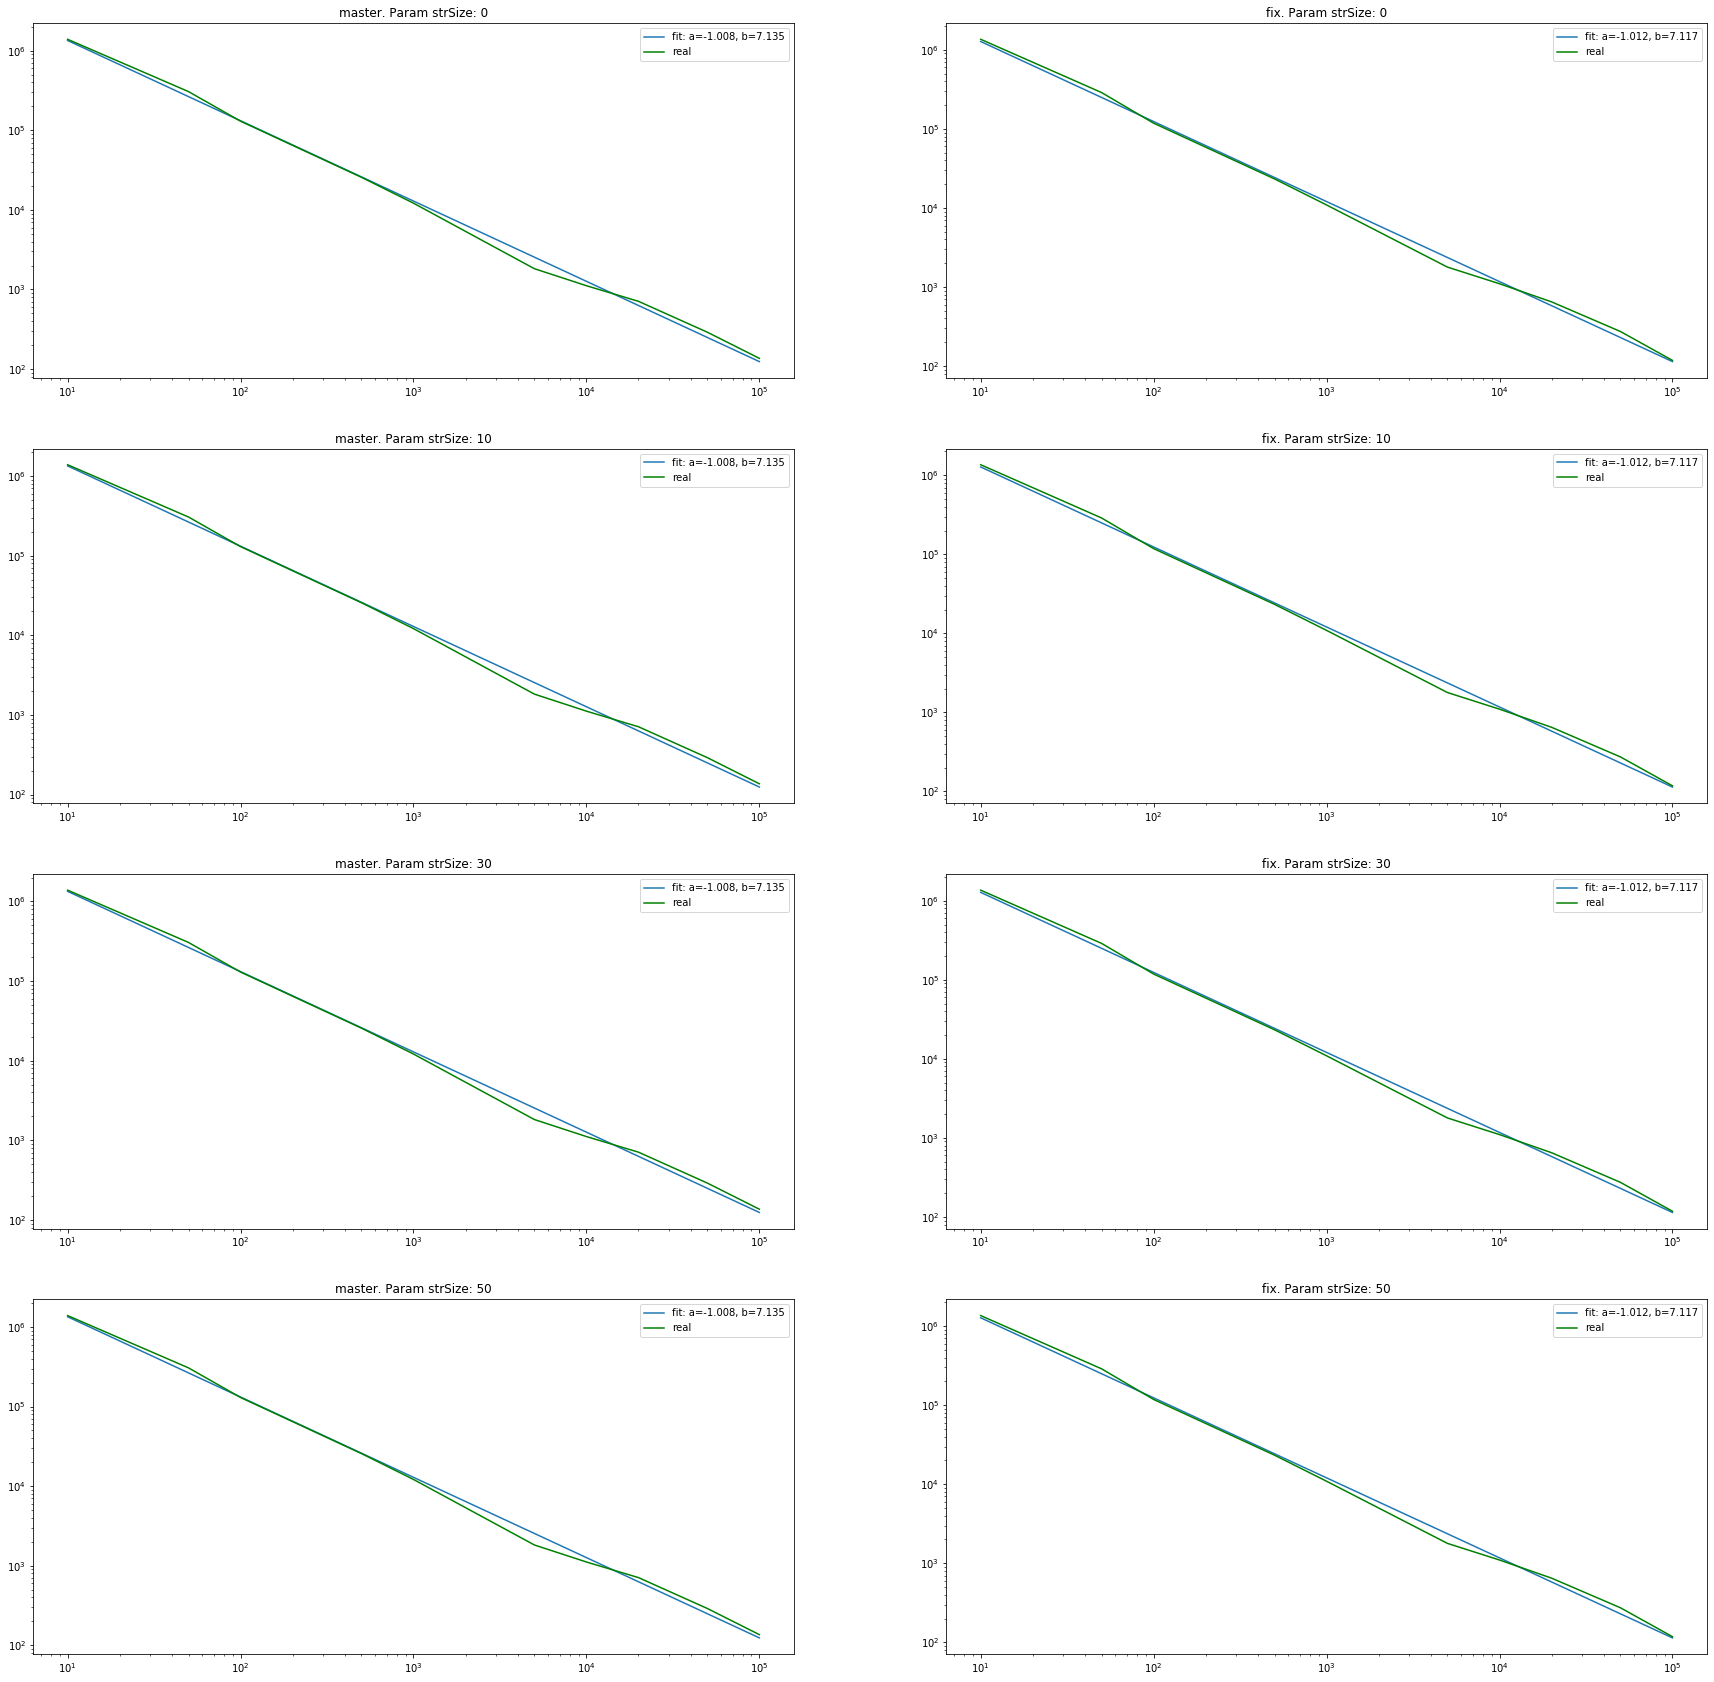

In [10]:
fit(master_256, fix_256)

## Fit for 128m

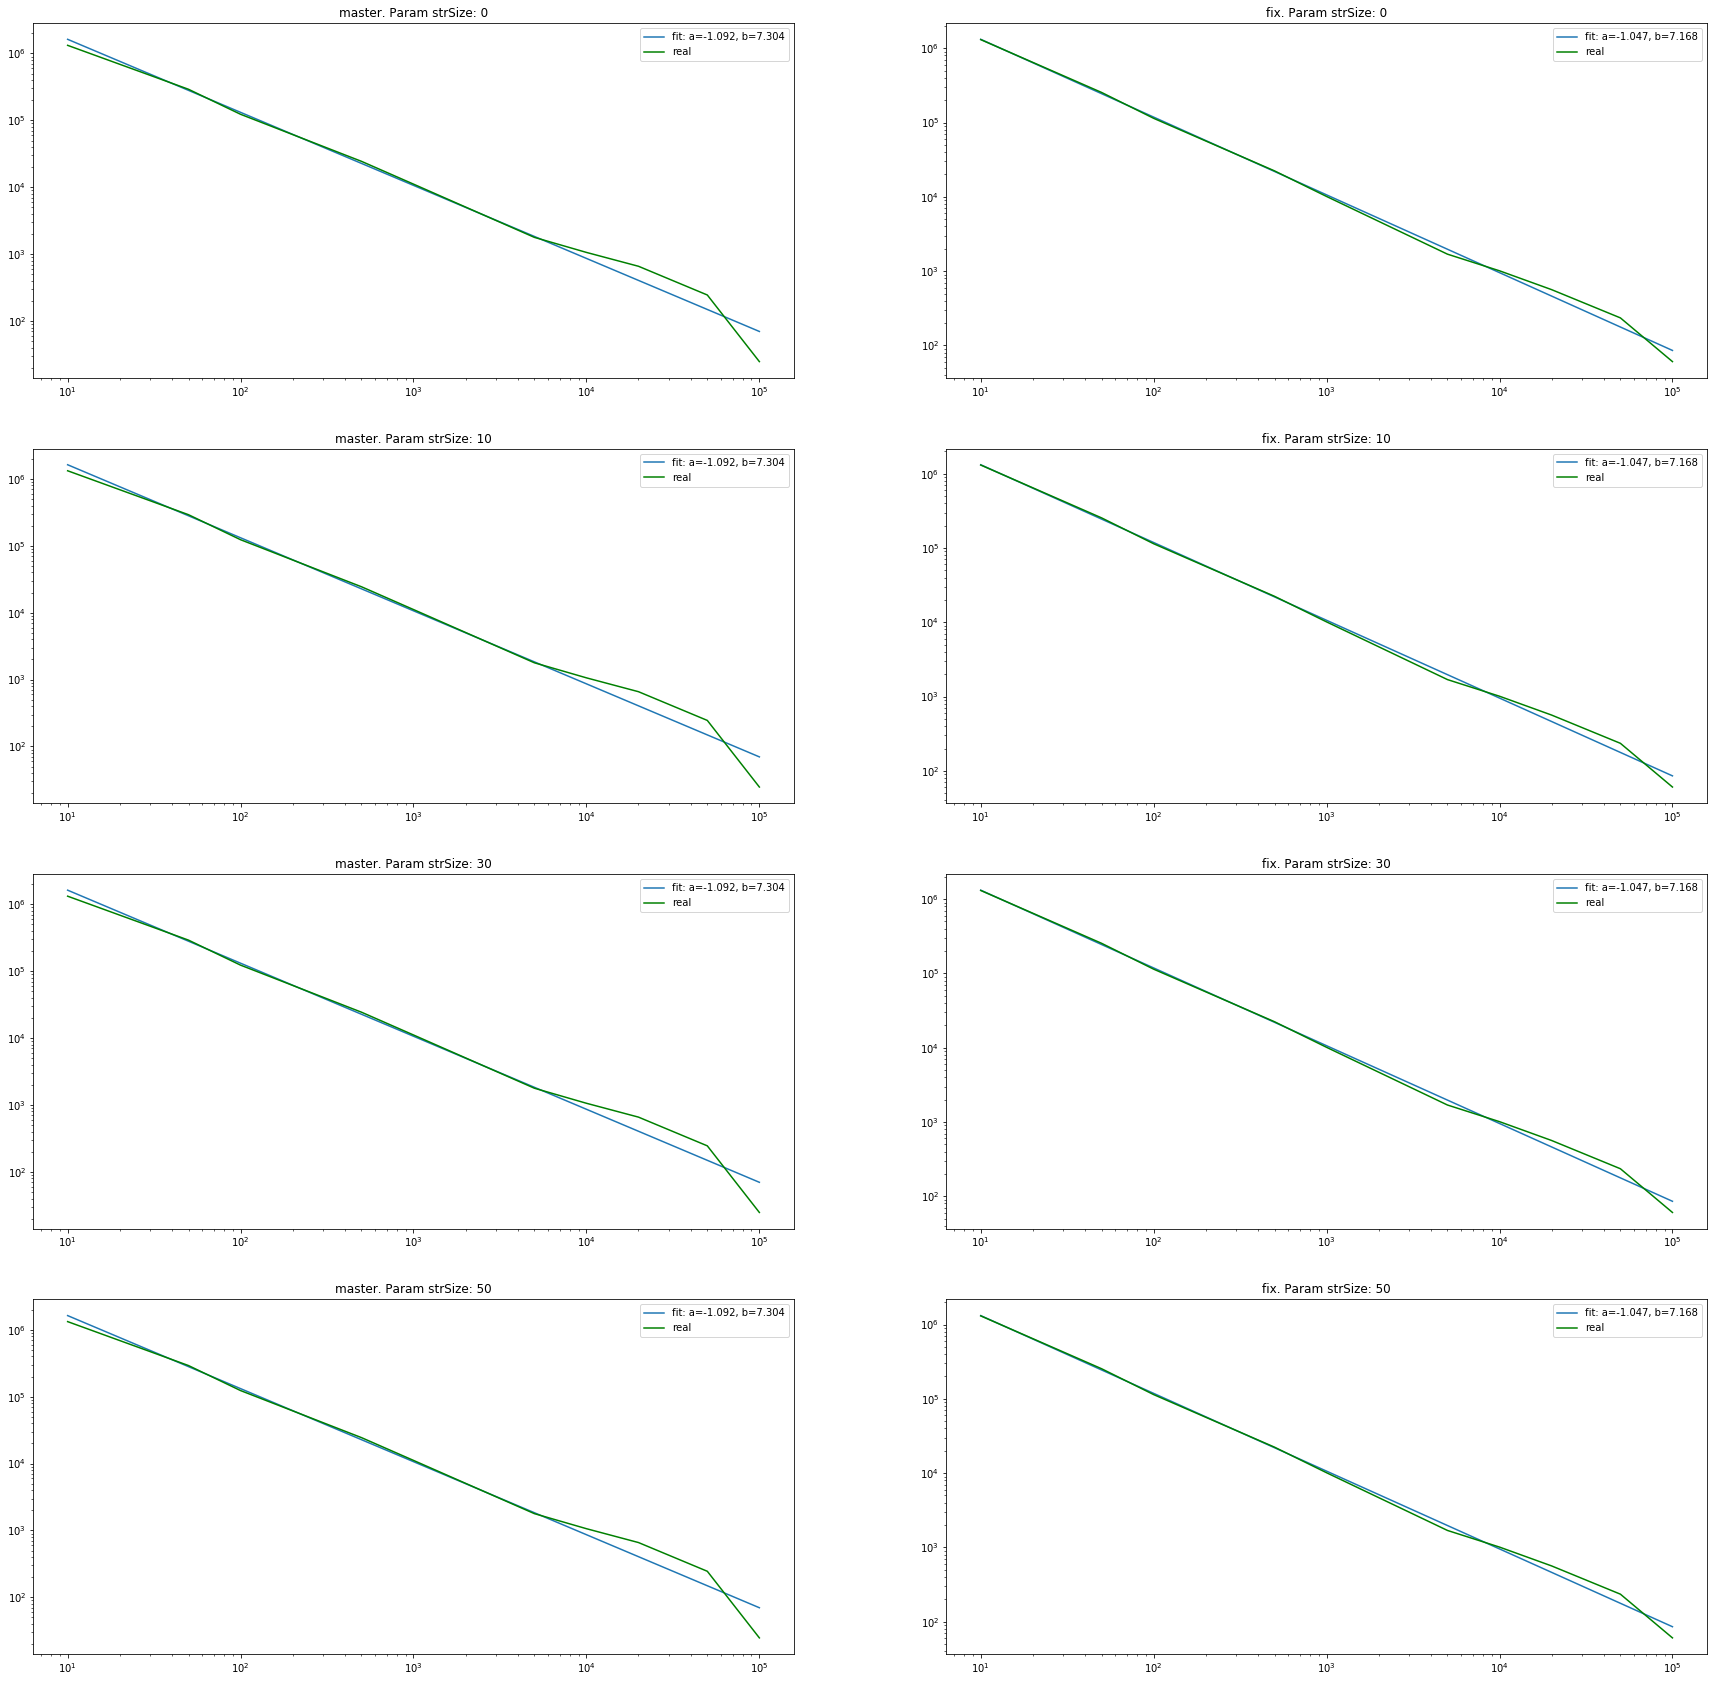

In [11]:
fit(master_128, fix_128)

## Fit for 64m

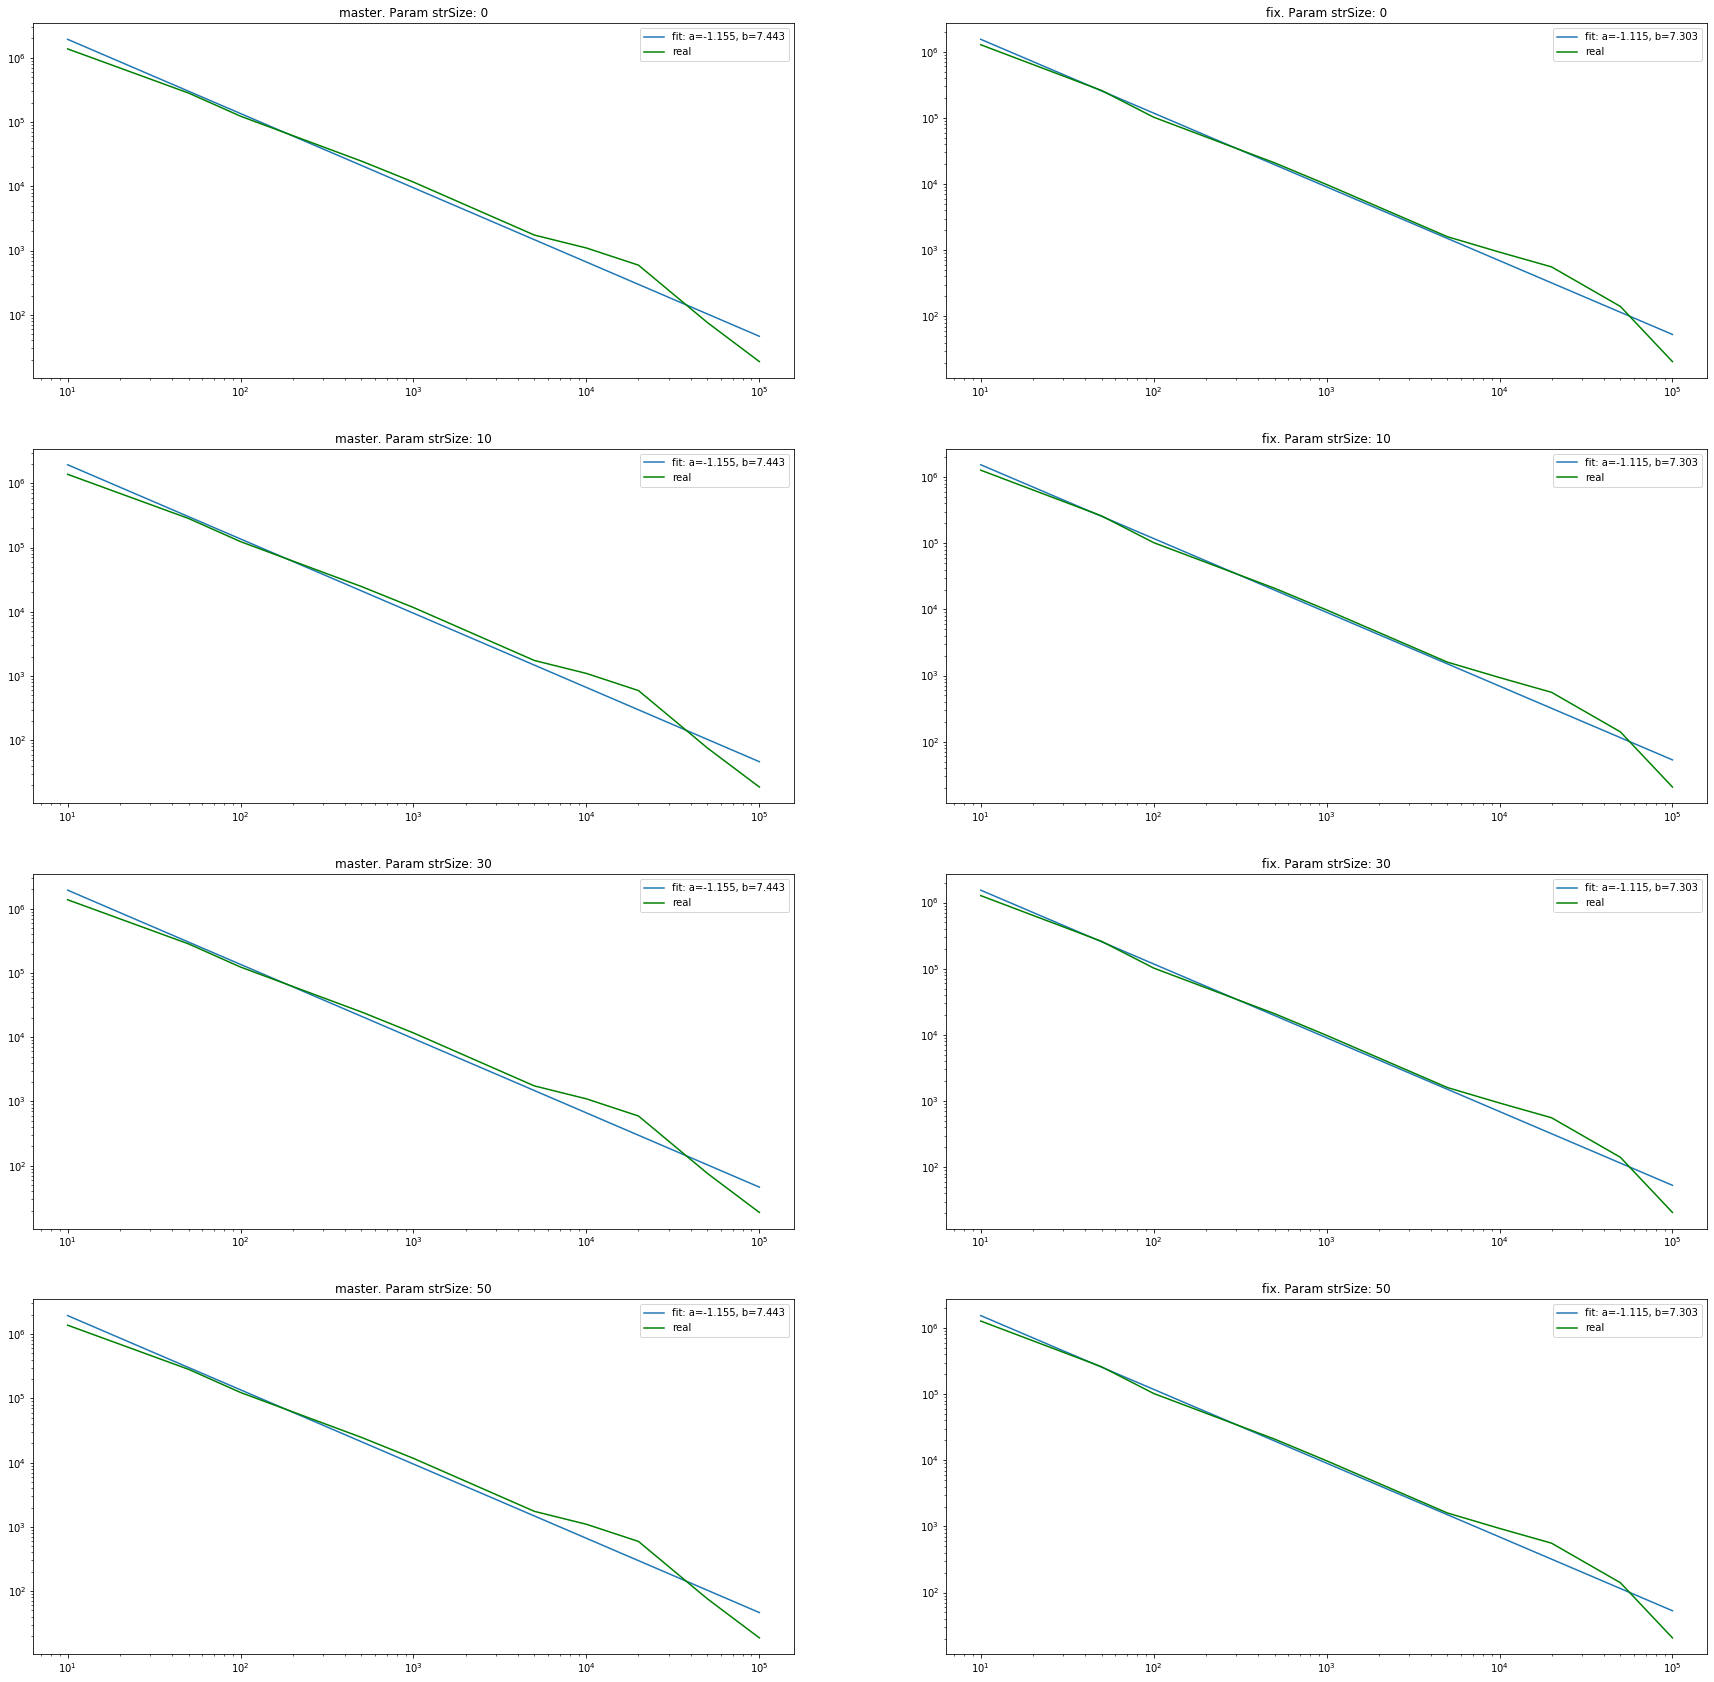

In [25]:
fit(master_64, fix_64)

In [26]:
data = {"strSize": [], "heap": [], "calculated_penalty": [], "mean_penalty": []}


for i in ["64", "128", "256", "512", "1g"]:
    master = globals()["master_%s" % i]
    fix = globals()["fix_%s" % i]
    
    for j in [0, 10, 30, 50]:
        _, detach_master = extract(master, j)
        _, detach_fix = extract(fix, j)

        popt_master = optimize(detach_master)
        popt_fix = optimize(detach_fix)
        
        data["mean_penalty"].append(detach_fix["Score"].mean()/detach_master["Score"].mean())
        data["calculated_penalty"].append(np.power(10, popt_fix[1])/np.power(10, popt_master[1]))
        data["heap"].append(i)
        data["strSize"].append(j)

pd.DataFrame(data) 

,strSize,heap,calculated_penalty,mean_penalty
0,0,64,0.723407,0.915508
1,10,64,0.723407,0.915508
2,30,64,0.723407,0.915508
3,50,64,0.723407,0.915508
4,0,128,0.730483,0.962614
5,10,128,0.730483,0.962614
6,30,128,0.730483,0.962614
7,50,128,0.730483,0.962614
8,0,256,0.959075,0.967537
9,10,256,0.959075,0.967537


Model doesn't looks good if heap is small

Lets examine real penalty and when _master_ is __worse__ than _fix_

In [27]:
def penalty(heap):
    fix = globals()["fix_%s" % heap]
    master = globals()["master_%s" % heap]
    
    penalty = fix[fix["Benchmark"] == "testUnmarshallingDetach"]
    master_detach = master[master["Benchmark"] == "testUnmarshallingDetach"]

    penalty["Master Score"] = master_detach["Score"]
    penalty["Penalty"] = penalty.apply(lambda row: row["Score"] / row["Master Score"], axis=1)
    
    return penalty

penalty_128 = penalty(128)
penalty_128[penalty_128["Penalty"] > 1]

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: size,Param: strSize,Master Score,Penalty
47,testUnmarshallingDetach,thrpt,1,20,356525.634388,3207.841739,ops/s,50,50,305061.332214,1.168701
49,testUnmarshallingDetach,thrpt,1,20,201218.549521,979.527261,ops/s,100,10,195974.711440,1.026758
50,testUnmarshallingDetach,thrpt,1,20,199675.815963,1504.495299,ops/s,100,30,199144.891285,1.002666
51,testUnmarshallingDetach,thrpt,1,20,192208.741669,1296.160381,ops/s,100,50,155482.747663,1.236206
54,testUnmarshallingDetach,thrpt,1,20,37683.324922,686.990752,ops/s,500,30,31107.720421,1.211382
55,testUnmarshallingDetach,thrpt,1,20,37158.967457,1024.890657,ops/s,500,50,31169.393517,1.192162
58,testUnmarshallingDetach,thrpt,1,20,19771.812986,618.392848,ops/s,1000,30,15700.283732,1.259328
59,testUnmarshallingDetach,thrpt,1,20,18584.490131,599.572720,ops/s,1000,50,15484.263576,1.200218
62,testUnmarshallingDetach,thrpt,1,20,3682.119878,38.899071,ops/s,5000,30,3352.624630,1.098280
63,testUnmarshallingDetach,thrpt,1,20,3408.120301,63.971452,ops/s,5000,50,3292.824979,1.035014


In [29]:
penalty_64 = penalty(64)
penalty_64[penalty_64["Penalty"] > 1]

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: size,Param: strSize,Master Score,Penalty
47,testUnmarshallingDetach,thrpt,1,20,344310.056144,4327.140742,ops/s,50,50,336585.070007,1.022951
51,testUnmarshallingDetach,thrpt,1,20,177031.204965,2377.493806,ops/s,100,50,172665.892437,1.025282
54,testUnmarshallingDetach,thrpt,1,20,37016.192765,378.012776,ops/s,500,30,35316.957504,1.048114
59,testUnmarshallingDetach,thrpt,1,20,17794.000100,269.329570,ops/s,1000,50,17573.546070,1.012545
70,testUnmarshallingDetach,thrpt,1,20,601.479833,16.595749,ops/s,20000,30,249.621156,2.409571
71,testUnmarshallingDetach,thrpt,1,20,515.497121,15.641920,ops/s,20000,50,235.548010,2.188501
72,testUnmarshallingDetach,thrpt,1,20,140.867175,3.439668,ops/s,50000,0,76.073269,1.851730
73,testUnmarshallingDetach,thrpt,1,20,110.791967,2.914189,ops/s,50000,10,62.143031,1.782854
74,testUnmarshallingDetach,thrpt,1,20,72.790861,1.682070,ops/s,50000,30,61.820090,1.177463
76,testUnmarshallingDetach,thrpt,1,20,20.653639,0.482258,ops/s,100000,0,18.716707,1.103487


And what about if heap is not so small?

In [28]:
penalty_1g = penalty("1g")
penalty_1g[penalty_1g["Penalty"] > 1]

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: size,Param: strSize,Master Score,Penalty
47,testUnmarshallingDetach,thrpt,1,20,394887.377128,2383.602012,ops/s,50,50,329518.575672,1.198377
51,testUnmarshallingDetach,thrpt,1,20,205674.346360,1527.235823,ops/s,100,50,160468.875256,1.281709
54,testUnmarshallingDetach,thrpt,1,20,42622.526522,161.086379,ops/s,500,30,35465.620400,1.201798
55,testUnmarshallingDetach,thrpt,1,20,41535.907155,248.736573,ops/s,500,50,35114.390070,1.182874
58,testUnmarshallingDetach,thrpt,1,20,21343.981247,148.497568,ops/s,1000,30,18167.657966,1.174834
59,testUnmarshallingDetach,thrpt,1,20,20769.105280,117.102155,ops/s,1000,50,18335.373274,1.132734
62,testUnmarshallingDetach,thrpt,1,20,3499.176646,18.971564,ops/s,5000,30,3474.815501,1.007011
63,testUnmarshallingDetach,thrpt,1,20,3748.862098,19.169659,ops/s,5000,50,3411.850622,1.098777
67,testUnmarshallingDetach,thrpt,1,20,1458.382275,8.346421,ops/s,10000,50,1405.301733,1.037772
70,testUnmarshallingDetach,thrpt,1,20,546.782116,3.468471,ops/s,20000,30,545.827150,1.001750
